In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2

from glob import glob
import matplotlib.pyplot as plt

In [2]:
calibration_images = [image_path for image_path in sorted(glob("../data/calibration/*.jpg")) if np.array_equal(cv2.imread(image_path).shape[:2],  np.array([720, 1280]))]


In [191]:
from matplotlib.patches import Circle

def extreme_rect(corners, nx):
    sq_corners = corners.squeeze()
    first_line = sq_corners[:nx] # extracts first line of corners (with nx)
    last_line = sq_corners[-nx:] # extracts last line of corners
    return {"tl": first_line[0], "tr": first_line[-1], "bl": last_line[0], "br": last_line[-1]}

def rect_dict2nparray(rect:dict) -> np.ndarray:
    return np.float32([rect["tl"], rect["tr"], rect["br"], rect["bl"]])

def draw_polygone(pts, image, isClosed = True, color=(0, 0, 255), thickness = 2):
    print(pts)
    return cv2.polylines(image, [pts.astype(int)],  isClosed, color, thickness)



def highlight_corners(ax, rect:dict, corner_color="red"):
    """ Rectangle/bounding box visualization tool."""
    ax.add_patch(Circle(rect.get("tl"), 10, color="red" ))
    ax.add_patch(Circle(rect.get("tr"), 10, color="red" ))
    ax.add_patch(Circle(rect.get("bl"), 10, color="red" ))
    ax.add_patch(Circle(rect.get("br"), 10, color="red" ))


{'tl': array([545.3228 , 343.05032], dtype=float32), 'tr': array([972.56885, 336.60718], dtype=float32), 'bl': array([538.43945, 575.4545 ], dtype=float32), 'br': array([922.8272, 549.9281], dtype=float32)}
[[545.3228  343.05032]
 [972.56885 336.60718]
 [922.8272  549.9281 ]
 [538.43945 575.4545 ]]


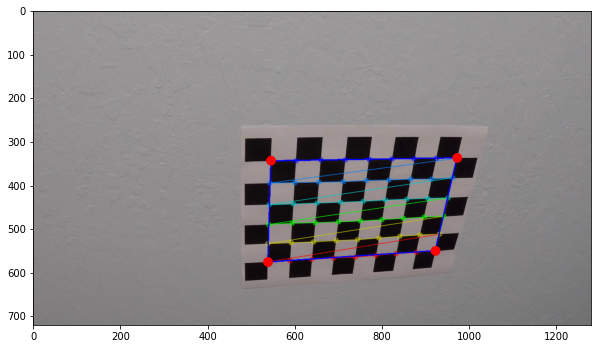

In [192]:
from loris.calibration.utils import detect_corners
nx = 9
ny = 6
sample_image = cv2.imread(calibration_images[1])
corners, shape = detect_corners(sample_image, nx=nx, ny=ny)
rect = extreme_rect(corners, 9)
print(rect)
plt.figure(figsize = (10, 10))
ax = plt.subplot(1, 1, 1)
ax.imshow(cv2.drawChessboardCorners(sample_image, (nx, ny), corners, True))
ax.imshow(draw_polygone(rect_dict2nparray(rect), sample_image))
highlight_corners(ax, rect)

In [193]:
# Sanity check (image shape)
for test_image in calibration_images:
    # print(f"{test_image} -> {cv2.imread(test_image).shape}")
    if not np.array_equal(cv2.imread(test_image).shape[:2],  [720, 1280]):
        print(f"{test_image}")

In [194]:
# ! mkdir -p ../data/calibration/shape-mismatch
# ! mv ../data/calibration/calibration15.jpg ../data/calibration/shape-mismatch/
# ! mv ../data/calibration/calibration7.jpg ../data/calibration/shape-mismatch/

## Calibrate and undistort image

In [195]:
from loris.calibration.utils import calibrate, undistort
calibration_output = calibrate(calibration_images)

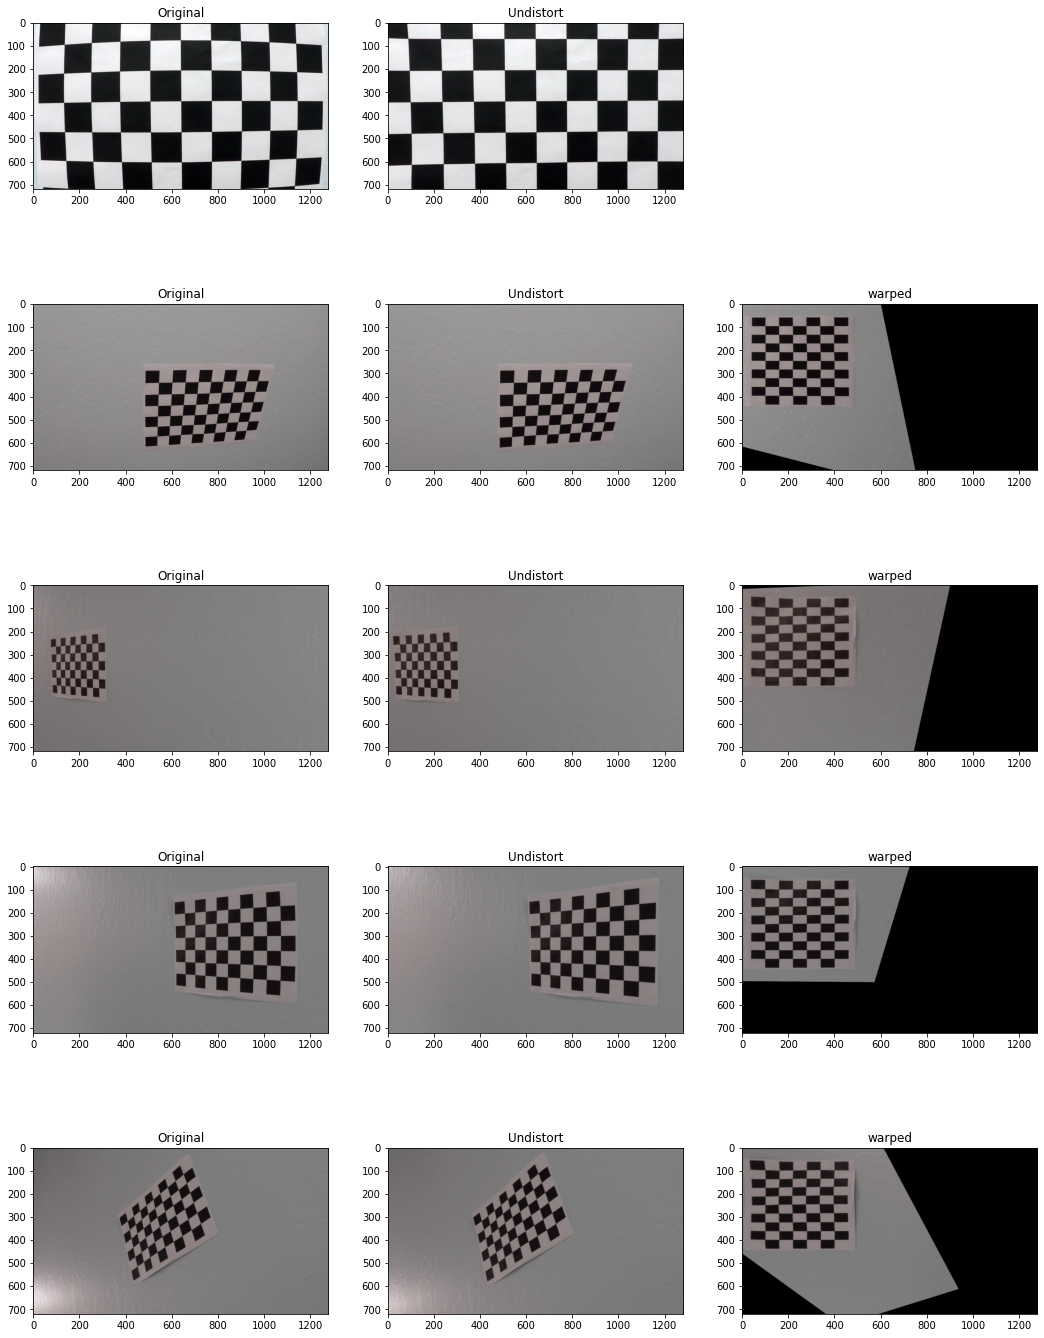

In [196]:
images_sample = calibration_images[:5]
plt.figure(figsize=(18, 5*len(images_sample)))
index = 1
for test_image in  map(cv2.imread, images_sample):
    orig_ax = plt.subplot(len(images_sample), 3, index)
    orig_ax.imshow(test_image)
    orig_ax.set_title("Original")
    status, output = undistort(test_image, calibration_output)
    if status:
        undistort_ax = plt.subplot(len(images_sample), 3, index+1)
        undistort_ax.imshow(output)
        undistort_ax.set_title("Undistort")

        # warp external rectangle
        corners, shape = detect_corners(output, nx=9, ny=6)
        if corners is not None:
            warped_ax = plt.subplot(len(images_sample), 3, index+2)

            rect = rect_dict2nparray(extreme_rect(corners, 9))
            M = cv2.getPerspectiveTransform(rect, np.float32([[100, 100], [100, 400], [400, 400], [400, 100]]))
            warped = cv2.warpPerspective(output, M, test_image.shape[:2][::-1], flags=cv2.INTER_LINEAR)
            warped_ax.imshow(warped)
            warped_ax.set_title("warped")
    index += 3

# Advanced lane detection

## Rectangular region extraction (sanity check)

In [248]:
straight_lines_images = list(glob("../data/lane_detection/test_images/straight*.jpg"))
print(straight_lines_images)

['../data/lane_detection/test_images/straight_lines1.jpg', '../data/lane_detection/test_images/straight_lines2.jpg']


[[320.   0.]
 [960.   0.]
 [960. 720.]
 [320. 720.]]


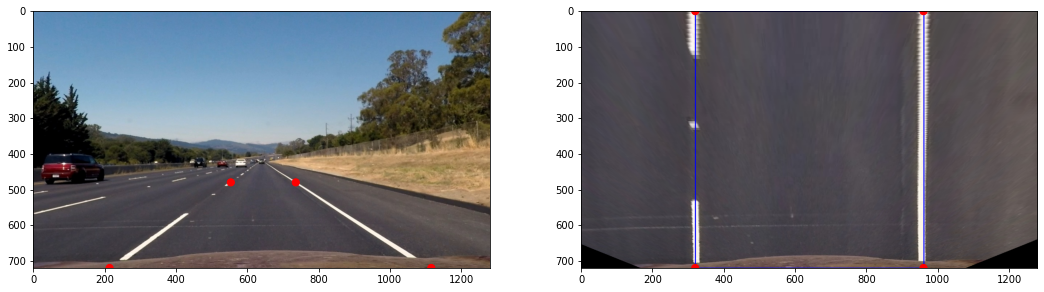

In [251]:
from loris.utils import warp
from loris.lane_detection.lane_detector import src, dest

sample_image = cv2.imread(straight_lines_images[1])

status, output = undistort(sample_image, calibration_output)
plt.figure(figsize=(18, 10))

if status:
        ax = plt.subplot(1, 2, 1)
        warped = warp(output, rect_dict2nparray(src), rect_dict2nparray(dest) )
        warped_ax = plt.subplot(1, 2, 2)
        ax.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        draw_rectangle(ax, src)
        warped_ax.imshow( draw_polygone(rect_dict2nparray(dest), cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)))
        highlight_corners(warped_ax, dest)

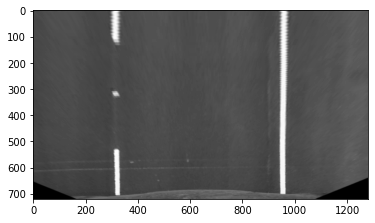

In [252]:
from loris.lane_detection.utils import grayscale, canny, gaussian_blur
plt.imshow((gaussian_blur(grayscale(warped))), cmap="gray")

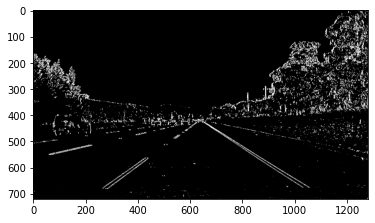

In [253]:
sobel_x = cv2.Sobel(grayscale(sample_image), cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobel_x)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

plt.imshow(sxbinary, cmap="gray")

In [254]:
from loris.lane_detection.threshold import  abs_sobel_thresh, mag_thresh, dir_threshold


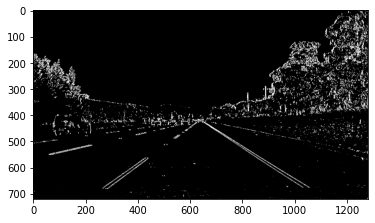

In [255]:
plt.imshow(abs_sobel_thresh(sample_image, thresh=(20,100)), cmap="gray")

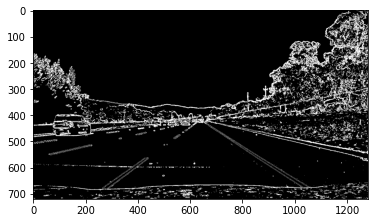

In [256]:
plt.imshow(mag_thresh(sample_image, mag_thresh=(20, 100)), cmap="gray")

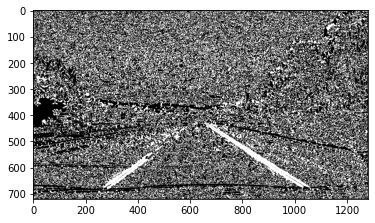

In [257]:
plt.imshow(dir_threshold(sample_image, sobel_kernel=15, thresh=(0.7, 1.3)), cmap="gray")

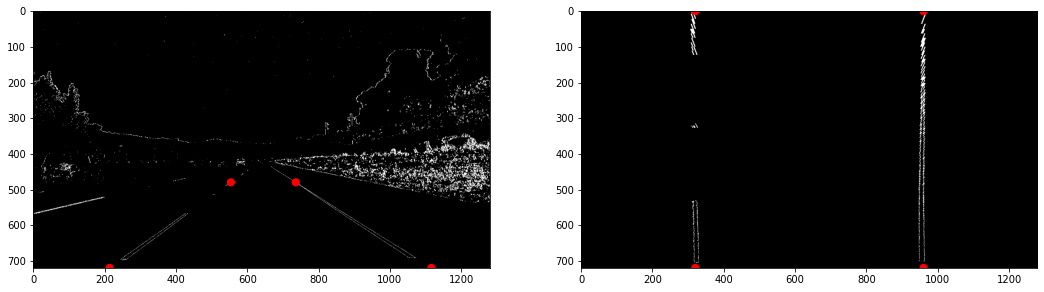

In [258]:
from loris.lane_detection.threshold import combined_threshold, threshold_pipeline
from loris.lane_detection.lane_detector import src, dest

status, output = undistort(sample_image, calibration_output)
combined = threshold_pipeline(output)

plt.figure(figsize=(18, 10))
ax = plt.subplot(1, 2, 1)
warped = warp(combined, rect_dict2nparray(src), rect_dict2nparray(dest) )
warped_ax = plt.subplot(1, 2, 2)
ax.imshow(combined, cmap="gray")
draw_rectangle(ax, src)
warped_ax.imshow(warped, cmap="gray")
draw_rectangle(warped_ax, dest)

In [259]:
import matplotlib.pyplot as plt

def hist(img):
    bottom_half = img[img.shape[0]//2:]
    return np.sum(bottom_half, axis=0)

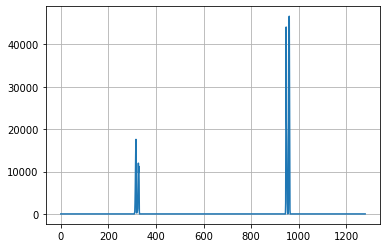

In [260]:
# Create histogram of image binary activations
histogram = hist(warped)
plt.plot(histogram)
plt.grid()

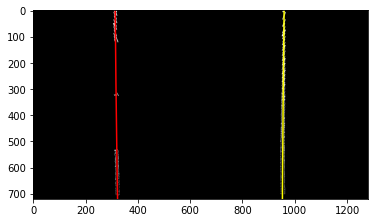

In [261]:
from loris.lane_detection.advanced import search_around_poly, non_zero, poly_fit, visualize, find_lane_pixels


leftx , lefty, rightx, righty = find_lane_pixels(warped)

left_fitx = poly_fit(lefty, leftx)
right_fitx = poly_fit(righty, rightx)

nonzerox, nonzeroy = non_zero(warped)
leftx, lefty, _ = search_around_poly(nonzerox, nonzeroy, left_fitx, margin=100)
rightx, righty, _ = search_around_poly(nonzerox, nonzeroy, right_fitx, margin=100)


visualize(warped, poly_fit(lefty, leftx) if leftx.shape[0] else left_fitx,  
          poly_fit(righty, rightx) if rightx.shape[0] else right_fitx)


## Radius of curvature

The radius of curvature.
$ R_{curve} = \frac{[[1+ {\frac{d_x}{d_y}}^2]^\frac{3}{2}]}{\frac{d^2x}{d_y}} $

Lane pixels are located (for each side) as second order polynomial $x=f(y)$

$f(y) = A y^2  + B y + C$

$ R_{curve} = \frac{[1 + [2*A*y+B]^2]^\frac{3}{2}}{2*A} $


In [262]:
def measure_curvature_pixels(left_fit, right_fit):
    """  Generates a right/left curve calculator from a left/right lane side
         (second order polynomial fit)
    :param left_fit: second order polynomial fit (left lane side)
    :param right+fit: second order polynomial fit (right lane side)
    """
    def right_left_curvature(y_eval):
        """ Calculation of R_curve (radius of curvature)"""
        left_curverad = pow(1 + pow((2*left_fit[0]*y_eval + left_fit[1]), 2), 3/2) / (2*np.abs(left_fit[0]))
        right_curverad = pow(1 + pow((2*right_fit[0]*y_eval + right_fit[1]), 2), 3/2) / (2*np.abs(right_fit[0]))

        return left_curverad, right_curverad

    return right_left_curvature

In [263]:
def convert(pixel_fit, x_meter_per_pixel, y_meter_per_pixel):
    """ Convert line poly fit from pixel to meter. """
    b_factor = x_meter_per_pixel/y_meter_per_pixel
    a_factor = b_factor / y_meter_per_pixel
    return pixel_fit * np.array([a_factor, b_factor, x_meter_per_pixel])

In [264]:
import numpy as np
np.array([1, 2, 3]) * np.array([2, 2, 4])

array([ 2,  4, 12])

In [265]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_fit = convert(left_fitx, xm_per_pix, ym_per_pix)
right_fit = convert(right_fitx, xm_per_pix, ym_per_pix)

measure_curvature_pixels(left_fit, right_fit)(0)

(29387.426756768447, 36664.53940958735)

## Pipeline

In [266]:
# test_images = sorted(glob("../data/lane_detection/test_images/test*"))
test_images = sorted(glob("../data/videos/frame_*"))

In [267]:
print(test_images)

['../data/videos/frame_0.jpg', '../data/videos/frame_1.jpg', '../data/videos/frame_2.jpg', '../data/videos/frame_3.jpg', '../data/videos/frame_4.jpg', '../data/videos/frame_5.jpg', '../data/videos/frame_6.jpg', '../data/videos/frame_7.jpg', '../data/videos/frame_8.jpg', '../data/videos/frame_9.jpg']


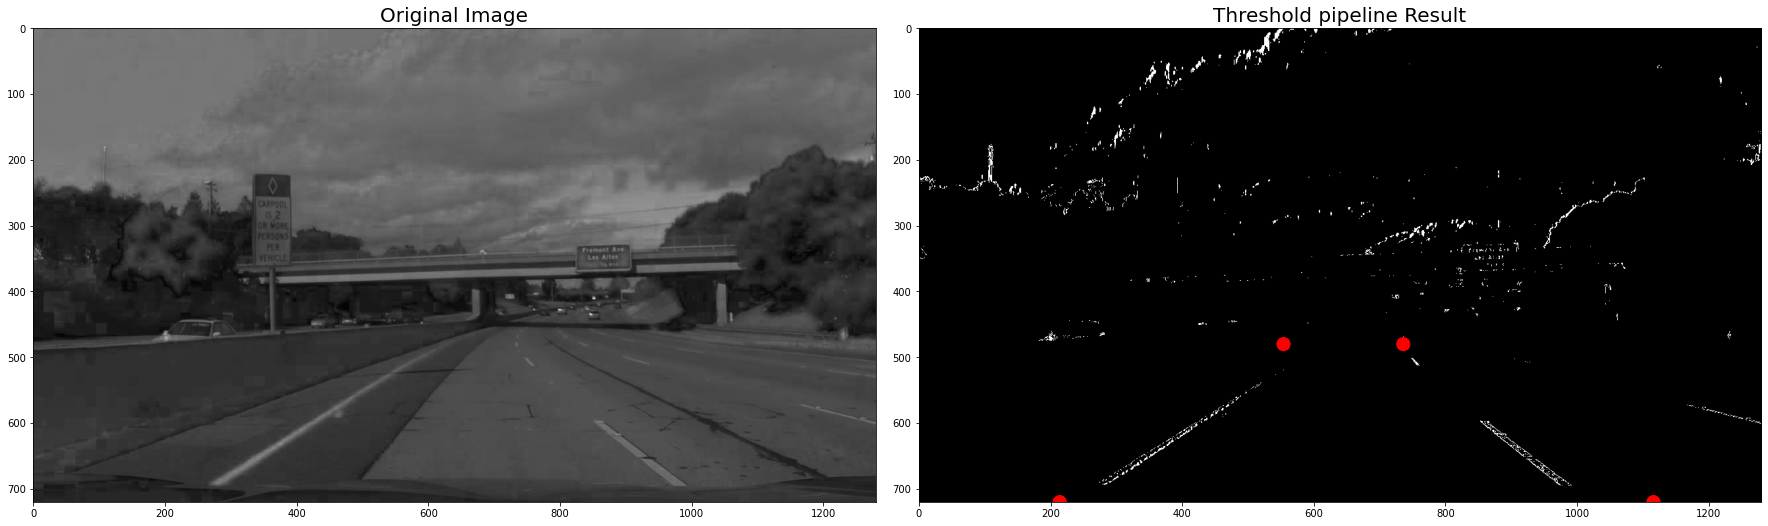

In [268]:
from loris.lane_detection.threshold import threshold_pipeline


sample_image = cv2.cvtColor(cv2.imread(test_images[2]), cv2.COLOR_BGR2RGB)
hls = cv2.cvtColor(sample_image, cv2.COLOR_RGB2HLS)
result =  threshold_pipeline(sample_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(np.mean(hls[:, :, 1:], axis=-1), cmap="gray")
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(result, cmap="gray")
ax2.set_title('Threshold pipeline Result', fontsize=20)
draw_rectangle(ax2, src)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



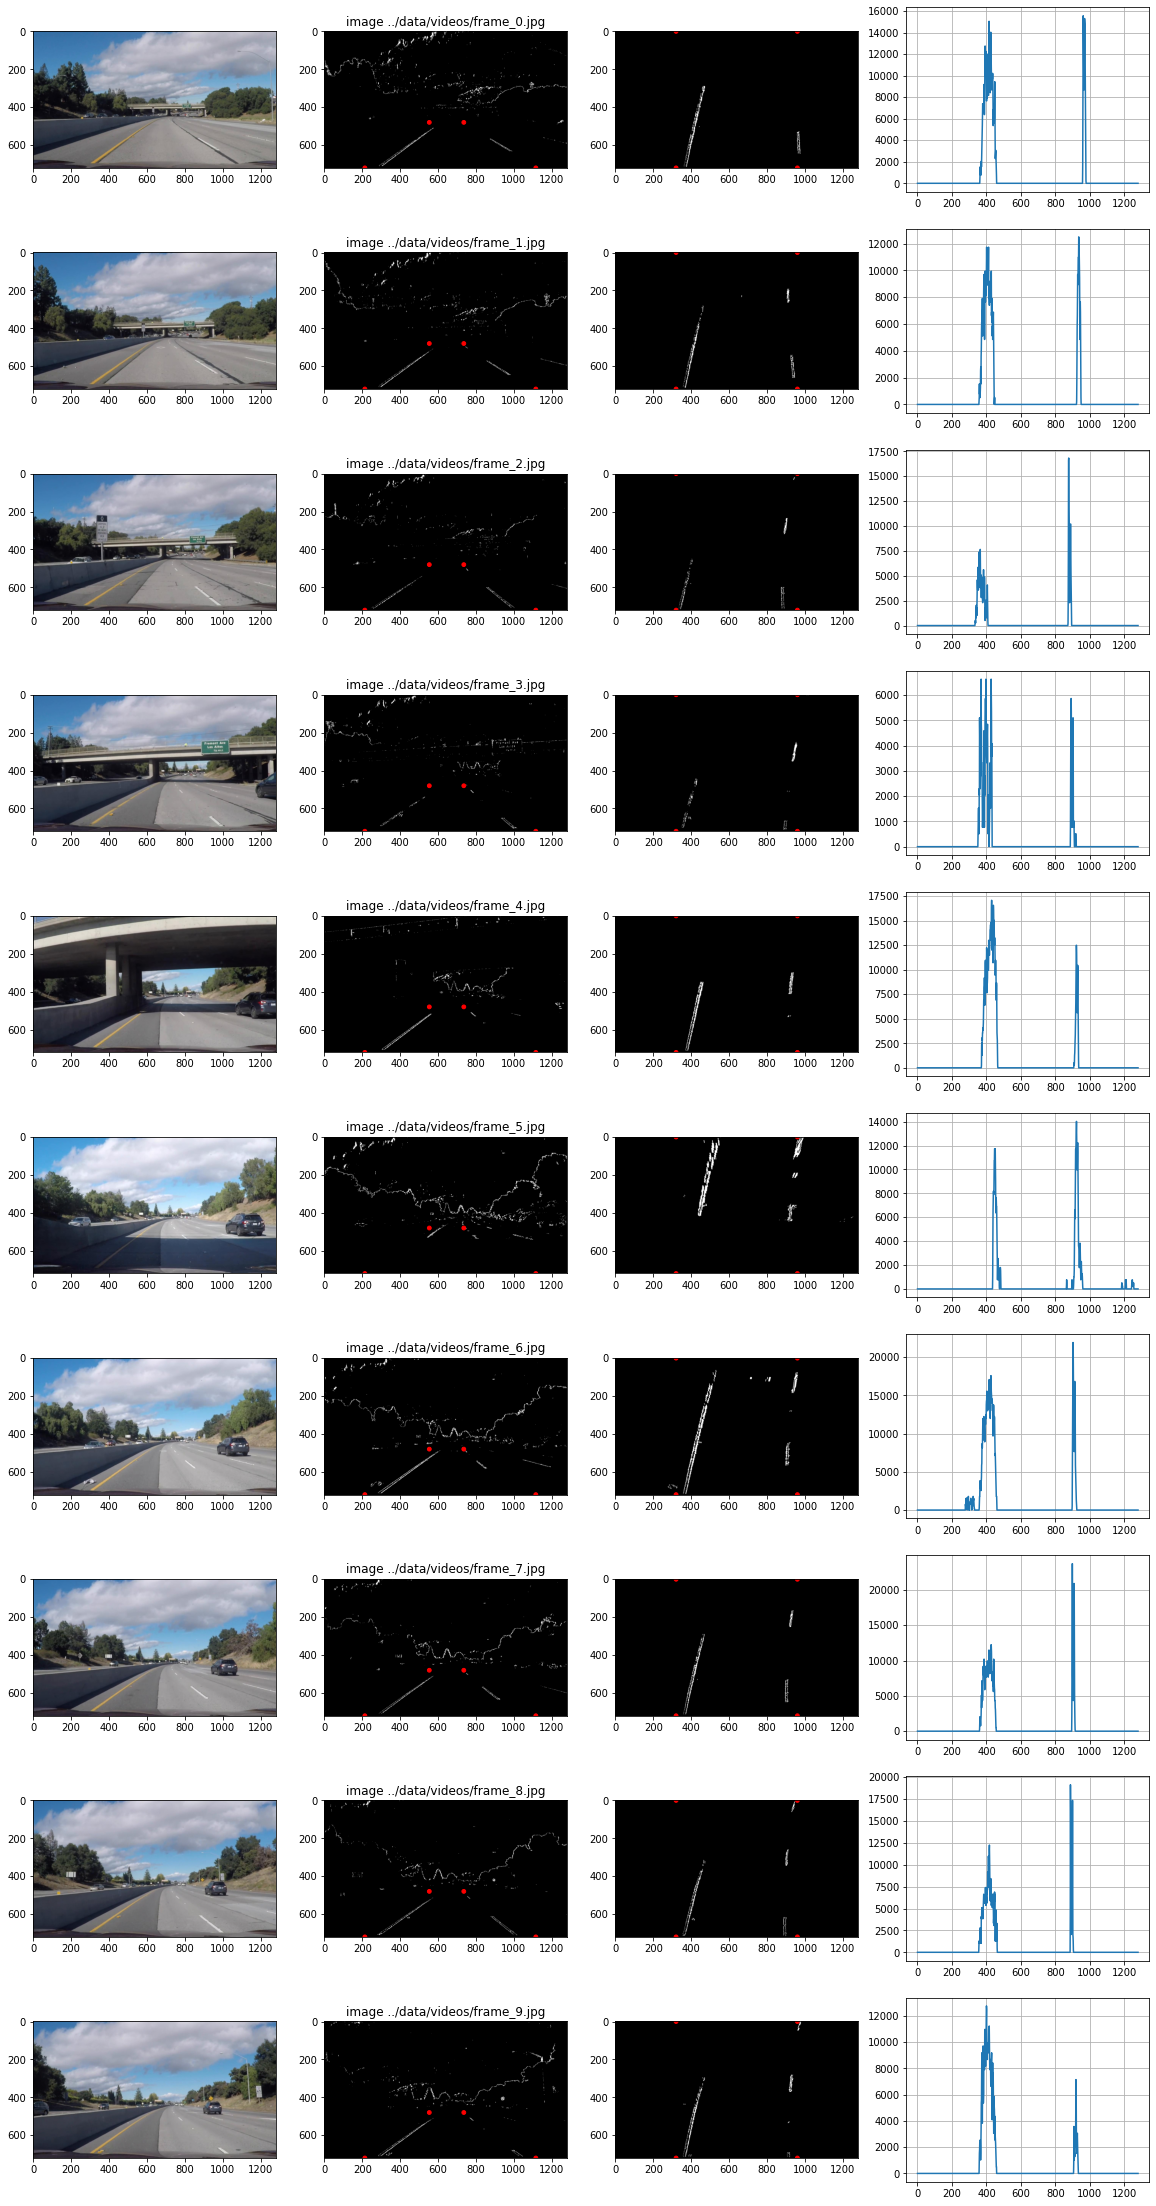

In [285]:
# src = {'tl': [600 , 500], 'tr': [760, 500], 'bl': [260, 720], 'br': [1100, 720]}
# dest =  {'tl': [320 , 0], 'tr': [960, 0], 'bl': [320, 720], 'br': [960, 720]}

from loris.lane_detection.lane_detector import src, dest

plt.figure(figsize=(20, len(test_images)*4))

index = 1
for image_path in test_images[:]:
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    status, output = undistort(image, calibration_output)
    if status:
        combined = threshold_pipeline(output)
        thresholded_warped = warp(combined, rect_dict2nparray(src), rect_dict2nparray(dest) )
        # orig_warped = 
        # leftx, lefty, rightx, righty = find_lane_pixels(thresholded_warped)
        # left_fitx, right_fitx = fit_poly(leftx, lefty, rightx, righty)


        ax_undistort = plt.subplot(len(test_images), 4, index)
        ax_undistort.imshow(image) # cv2.cvtColor(output, cv2.COLOR_HLS2RGB))

        ax = plt.subplot(len(test_images), 4, index+1)
        # ax.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        ax.imshow(combined, cmap="gray")
        ax.set_title(f"image {image_path}")
        draw_rectangle(ax, src)# TODO replace with polynomial plot

        warped_ax = plt.subplot(len(test_images), 4, index+2)
        warped_ax.imshow(thresholded_warped, cmap="gray")
        # visualize(thresholded_warped, left_fitx, right_fitx, warped_ax)
        draw_rectangle(warped_ax, dest)

        # lane x hitogram (white pixel positions)
        lane_hist_ax = plt.subplot(len(test_images), 4, index+3)
        lane_hist_ax.plot(hist(thresholded_warped))
        lane_hist_ax.grid()

    index += 4

## Lane detection on video


In [286]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from loris.lane_detection.lane_detector import LaneDetector


In [287]:
ld = LaneDetector(calibration_params=calibration_output, margin = 30)
ld.process_image(cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB))
# visualize(ld.binary_warped, ld.left.current_fit, ld.right.current_fit, plt)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

<Figure size 1440x2592 with 0 Axes>

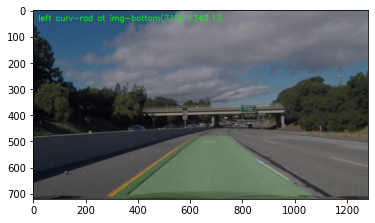

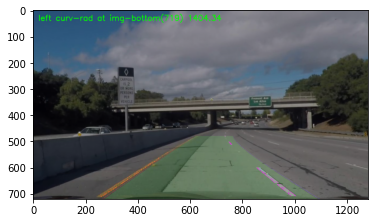

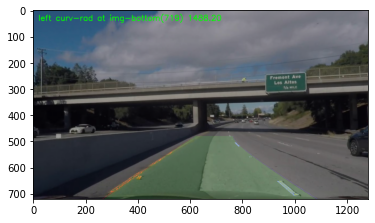

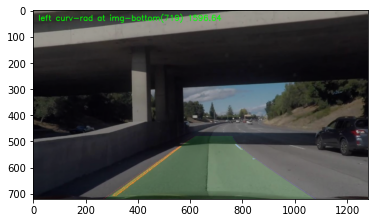

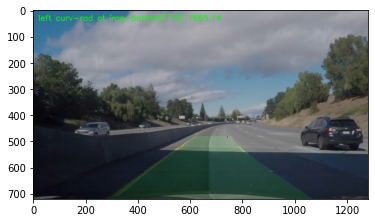

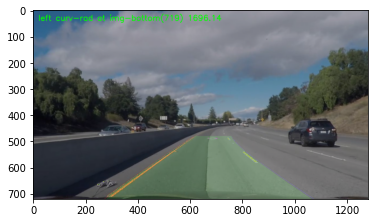

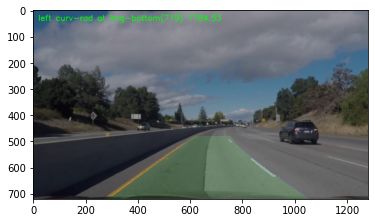

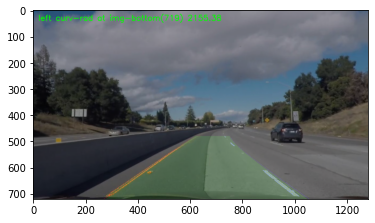

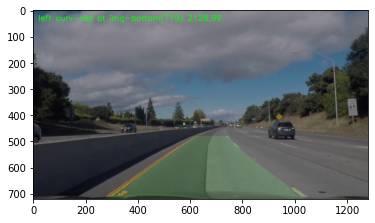

In [289]:
plt.figure(figsize=(20, (len(test_images)-1)*4))

for image_path in test_images[1:]:
    plt.figure()
    plt.imshow(ld.process_image(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)))
    # visualize(ld.binary_warped, ld.left_fitx, ld.right_fitx, plt)

In [290]:
# load video
challenge_video = VideoFileClip('../data/videos/challenge_video.mp4') # .subclip(0,10)
# Extract some frames for testing
# for ts in range(10):
#     challenge_video.save_frame(f"../data/videos/frame_{ts}.jpg", ts)

In [294]:

output_video = '../data/videos/challenge_video_output.mp4'
ld = LaneDetector(calibration_params=calibration_output, margin=60, look_back=20)
processed_clip = challenge_video.fl_image(ld.process_image) # expects color image output returned by process image
%time processed_clip.write_videofile(output_video, audio=False)

Moviepy - Building video ../data/videos/challenge_video_output.mp4.
Moviepy - Writing video ../data/videos/challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready ../data/videos/challenge_video_output.mp4
CPU times: user 1min 17s, sys: 12.1 s, total: 1min 29s
Wall time: 22.5 s


In [295]:
ld.processed_images


486

In [296]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))